# ML: Classification with imbalanced data

In [100]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime 
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve,roc_auc_score, zero_one_loss
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
#create timer func
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [3]:
#set dir
os.chdir('C:\\Users\\Josh\\Documents\\Python Scripts\\bank')

f = open('bank-names.txt', 'r')
file_contents = f.read()
print (file_contents)

Citation Request:
  This dataset is public available for research. The details are described in [Moro et al., 2011]. 
  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, GuimarÃ£es, Portugal, October, 2011. EUROSIS.

  Available at: [pdf] http://hdl.handle.net/1822/14838
                [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

1. Title: Bank Marketing

2. Sources
   Created by: Paulo Cortez (Univ. Minho) and SÃ©rgio Moro (ISCTE-IUL) @ 2012
   
3. Past Usage:

  The full dataset was described and analyzed in:

  S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European

In [4]:
f.close()
#%% import
data = pd.read_csv('bank-full.csv', sep=";",na_values = "")
data = data.sample(frac=1).reset_index(drop=True) #shuffle
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,student,married,tertiary,no,324,no,no,cellular,25,aug,585,4,-1,0,unknown,no
1,35,unemployed,single,secondary,no,295,no,no,unknown,17,mar,473,1,-1,0,unknown,yes
2,54,services,married,secondary,no,386,yes,no,cellular,2,aug,155,2,-1,0,unknown,no
3,43,services,single,secondary,no,21,no,no,cellular,3,feb,203,3,-1,0,unknown,no
4,43,services,single,secondary,no,2444,no,yes,cellular,2,jun,130,1,-1,0,unknown,no


In [5]:
#%% explore
data.shape #get number of features and rows

(45211, 17)

In [6]:
data.isnull().sum() #data is already clean :)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [7]:
data.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


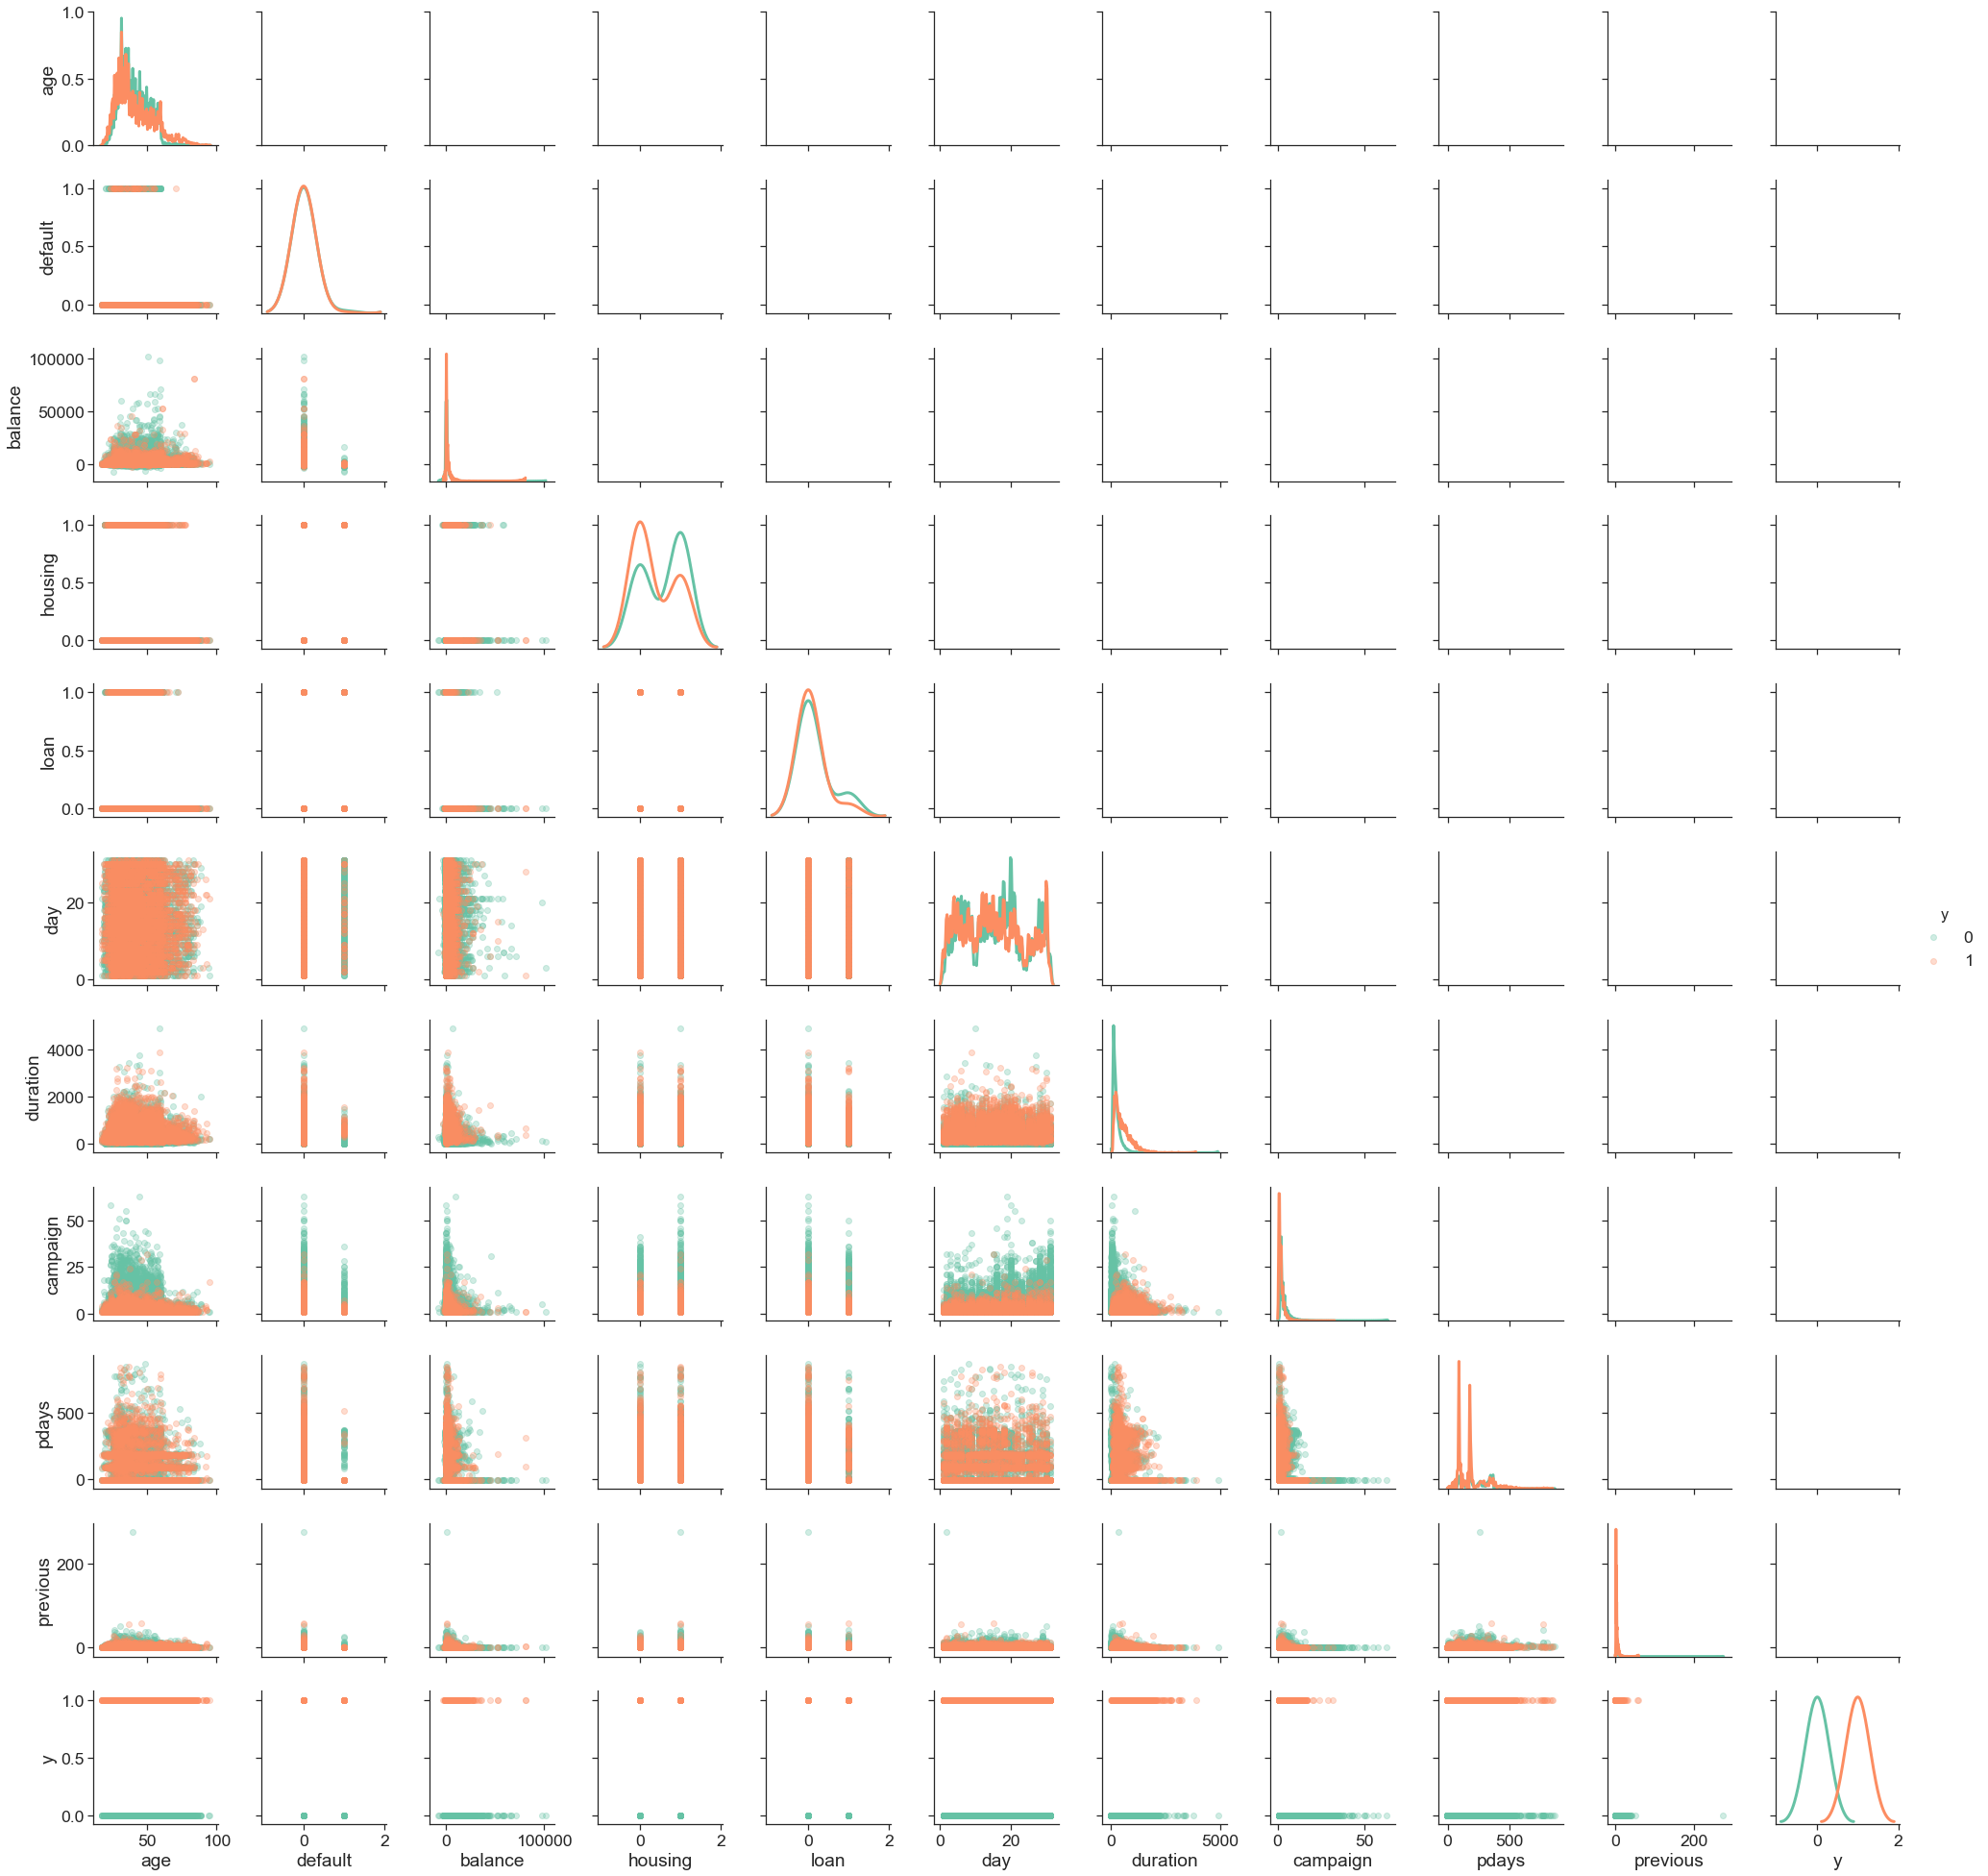

In [118]:
#viz
sns.set(font_scale=1.6, style="ticks")
pg = sns.PairGrid(data=data, diag_sharey=False, hue='y', palette='Set2')
pg.map_diag(sns.kdeplot, lw = 3, legend = False, bw=.30)
pg.map_lower(plt.scatter, alpha=0.3)
pg.add_legend()

In [5]:
data.groupby('job').agg('mean').round(1)

,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,
admin.,39.3,1135.8,15.6,246.9,2.6,47.9,0.7
blue-collar,40.0,1078.8,15.4,262.9,2.8,44.0,0.5
entrepreneur,42.2,1521.5,15.7,256.3,2.8,32.5,0.5
housemaid,46.4,1392.4,16.0,245.8,2.8,21.5,0.4
management,40.4,1763.6,16.1,254.0,2.9,38.7,0.7
retired,61.6,1984.2,15.4,287.4,2.3,37.4,0.6
self-employed,40.5,1648.0,16.0,268.2,2.9,34.7,0.6
services,38.7,997.1,15.6,259.3,2.7,42.0,0.5
student,26.5,1388.1,14.9,246.7,2.3,57.0,1.0


In [185]:
data.groupby('y').agg('mean').round(1)

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,40.8,1303.7,15.9,221.2,2.8,36.4,0.5
yes,41.7,1804.3,15.2,537.3,2.1,68.7,1.2


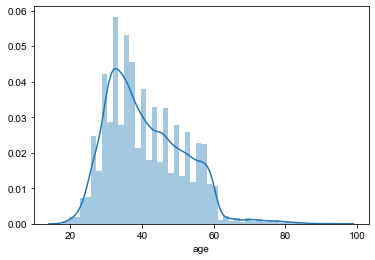

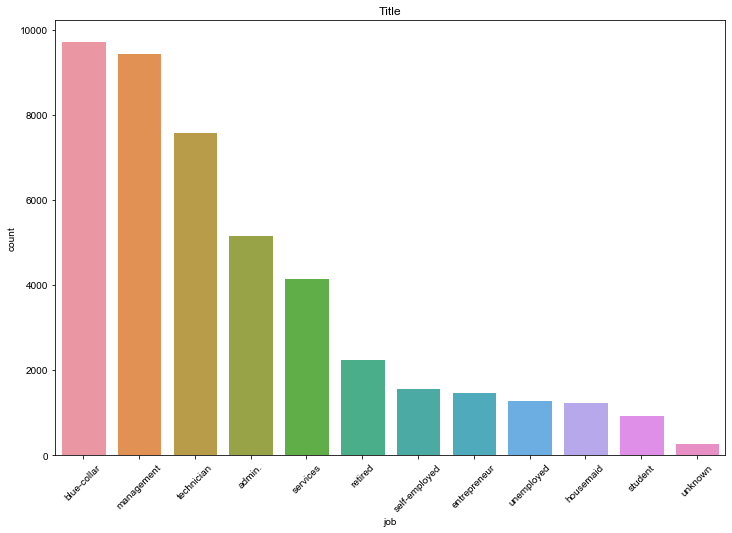

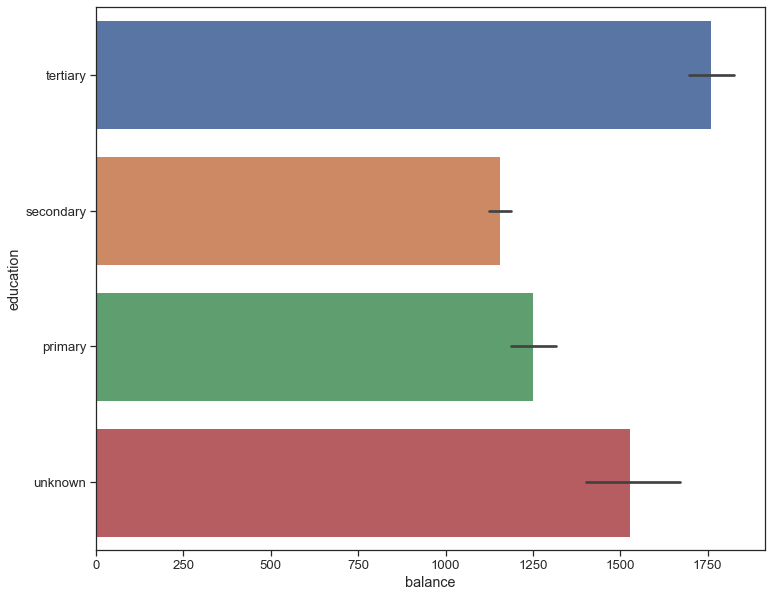

In [8]:
sns.distplot(data['campaign']) 

plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.title('Title')
sns.set(font_scale=1.4)
sns.countplot(x='job', data=data, order=data.job.value_counts().iloc[:12].index)

plt.figure(figsize=(12,10))
sns.set(style='ticks', font_scale=1.2)
sns.barplot(x='balance', y='education',data=data)

In [7]:
#%% pre-processing
data.replace(to_replace= ['no','yes'], value = [0,1], inplace=True)
preds = data.drop(['y'], axis=1)
target = data['y']

encoder = LabelEncoder()
encoder = encoder.fit(target)
target = encoder.transform(target)

encoder2 = ce.BaseNEncoder(cols = ['job', 'marital', 'education', 'default', 
                                  'housing', 'loan', 'contact', 'month', 'poutcome'])
encoder2 = encoder2.fit(preds)
preds = encoder2.transform(preds)

scaler = StandardScaler()
scaled_preds = scaler.fit_transform(preds)
preds_df = pd.DataFrame(scaled_preds, index=data.index, columns=preds.columns)

In [10]:
target

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [11]:
preds_df.head()

,age,job_0,job_1,job_2,job_3,job_4,marital_0,marital_1,marital_2,education_0,...,month_2,month_3,month_4,duration,campaign,pdays,previous,poutcome_0,poutcome_1,poutcome_2
0,-0.841558,0.0,-0.479301,-1.076699,-0.935395,1.226858,0.0,-0.813212,0.628090,-0.206962,...,-0.653575,-0.919509,0.661235,1.207017,0.076230,-0.411453,-0.25194,-0.348687,-0.282936,0.406524
1,-0.935732,0.0,-0.479301,-1.076699,1.069067,-0.815090,0.0,-0.813212,0.628090,-0.206962,...,-0.653575,1.087536,-1.512322,-0.800556,-0.569351,-0.411453,-0.25194,-0.348687,-0.282936,0.406524
2,-0.559037,0.0,-0.479301,-1.076699,1.069067,1.226858,0.0,-0.813212,0.628090,-0.206962,...,-0.653575,1.087536,-1.512322,-0.513205,-0.569351,-0.411453,-0.25194,-0.348687,-0.282936,0.406524
3,-0.747384,0.0,-0.479301,0.928765,-0.935395,-0.815090,0.0,1.229691,-1.592128,-0.206962,...,-0.653575,1.087536,0.661235,-0.202555,-0.246560,-0.411453,-0.25194,-0.348687,-0.282936,0.406524
4,-0.653211,0.0,-0.479301,-1.076699,-0.935395,1.226858,0.0,-0.813212,0.628090,-0.206962,...,-0.653575,-0.919509,0.661235,5.703668,0.721811,-0.411453,-0.25194,-0.348687,-0.282936,0.406524


In [13]:
#test-train-val split (60% - 20% - 20%)
X_train, X_test, y_train, y_test = train_test_split(preds_df, target, test_size=0.20, random_state=20)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=31)

print (X_train_val.shape, y_train_val.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(27126, 35) (27126,)
(9042, 35) (9042,)
(9043, 35) (9043,)


# Logistic Regression

In [84]:
C_vals = np.arange(1,11)

In [94]:
scores_tr = []
scores_val = []
for C in C_vals:
    clf = LogisticRegression(dual = False, penalty = 'l2', C=C)
    clf.fit(X_train_val, y_train_val)
    
    pred=clf.predict(X_train_val)
    scores_tr.append(accuracy_score(y_train_val, pred))
    
    pred=clf.predict(X_val)
    scores_val.append(accuracy_score(y_val,pred))    

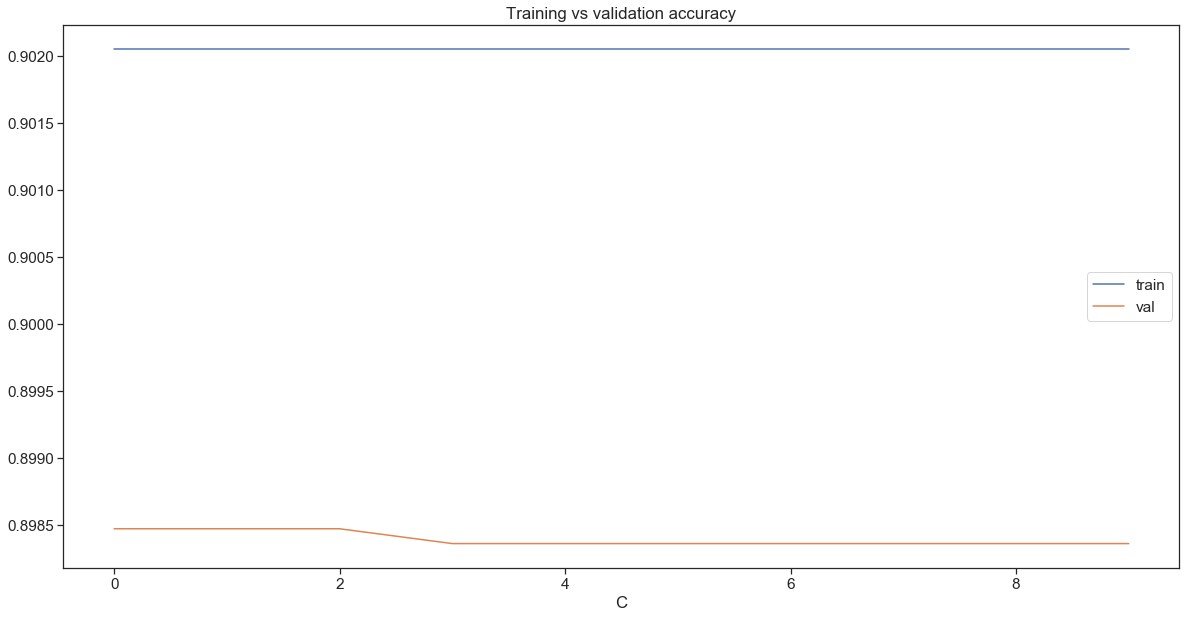

In [95]:
sns.set(font_scale=1.4, style='ticks')
plt.figure(figsize=(20,10))
plt.title('Training vs validation accuracy')
plt.plot(scores_tr, label = 'train')
plt.plot(scores_val, label = 'val')
plt.xlabel('C')
plt.legend()
plt.show()

In [89]:
#%% Specify-Compile
model_log = LogisticRegression(dual = False, penalty = 'l2')

params = {
        'max_iter': [100,110,120,130,140,150],
        'C' : [0.5, 1, 1.5, 2, 2.5, 3]
         }

model_log = RandomizedSearchCV(model_log,param_distributions=params, 
                                   scoring = 'roc_auc',
                                   cv = 3,
                                   n_iter=20,
                                   n_jobs=4,
                                   refit = True,
                                   verbose = 2,
                                   random_state = 1205)

In [14]:
#%% fit
start_time = timer(None) # timing starts from this point for "start_time" variable
model_log.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    3.9s finished



 Time taken: 0 hours 0 minutes and 4.27 seconds.


In [15]:
print(model_log.best_params_)

{'max_iter': 140, 'dual': False, 'C': 1.0}


In [16]:
Score_log = model_log.score(X_train, y_train)
print("Score: %.2f%%" % (Score_log * 100.0))

Score: 89.94%


In [17]:
#%% pickle model with best params
joblib_file = "joblib_log_Model.pkl" 
best_model = model_log.best_estimator_
joblib.dump(best_model, joblib_file)

['joblib_log_Model.pkl']

In [18]:
#%% Addressing class imbalance via SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
model_log2 = LogisticRegression(max_iter=150, C=3.0)
model_log2.fit(X_train_res, y_train_res)

Using TensorFlow backend.


LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
Score_logSMOTE = model_log2.score(X_train, y_train)
print("Score: %.2f%%" % (Score_logSMOTE * 100.0))

Score: 83.84%


In [20]:
#%% pickle model
joblib_file = "joblib_logSMOTE_Model.pkl"  
joblib.dump(model_log2, joblib_file)

['joblib_logSMOTE_Model.pkl']

# Random Forest

In [21]:
#%% Specify-Compile
model_RF = RandomForestClassifier(n_estimators=1000,criterion='entropy', class_weight='balanced')

params = {         
            'min_samples_split': [8,10],
            'max_depth': [10,12,14,16]
         }  

model_RF = RandomizedSearchCV(model_RF,param_distributions=params, 
                                   scoring = 'roc_auc',
                                   cv = 3,
                                   n_jobs=4,
                                   refit = True,
                                   return_train_score=True,
                                   verbose = 2,
                                   random_state = 2049)

In [22]:
#fit
start_time = timer(None) 
model_RF.fit(X_train, y_train)
timer(start_time) 

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:  3.4min finished



 Time taken: 0 hours 4 minutes and 0.81 seconds.


In [23]:
print(model_RF.best_params_)

{'min_samples_split': 10, 'max_depth': 16}


In [24]:
Score_RF = model_RF.score(X_train, y_train)
print("Score: %.2f%%" % (Score_RF * 100.0))

Score: 98.93%


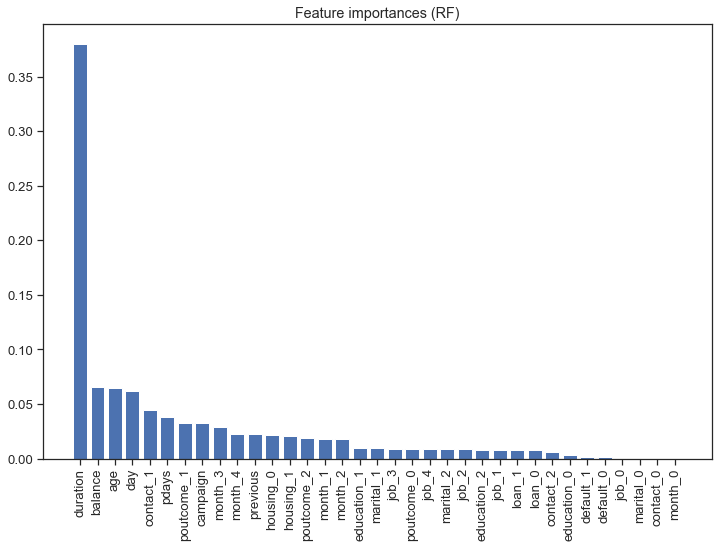

In [25]:
#feature importance
importances = model_RF.best_estimator_.feature_importances_
headers = ["var", "score"]
values = sorted(zip(X_train.columns, importances), key=lambda x: x[1] * -1)
imp = pd.DataFrame(values, columns = headers)

#plot
x_pos = np.arange(0, len(imp))
plt.figure(figsize=(12,8))
plt.bar(x_pos, imp['score'])
plt.xticks(x_pos, imp['var'])
plt.xticks(rotation=90)
plt.title('Feature importances (RF)')

plt.show()

In [26]:
#%% pickle model
joblib_file = "joblib_RF_Model.pkl"
best_model = model_RF.best_estimator_
joblib.dump(best_model, joblib_file)

['joblib_RF_Model.pkl']

# XGBoost

In [27]:
#to derive scale_pos_weight
neg = np.array(np.unique(y_train, return_counts=True))[1,0]
pos = np.array(np.unique(y_train, return_counts=True))[1,1]
sp_weight = neg/pos

model_XGB = xgb.XGBClassifier(objective='binary:logistic', tree_method = 'hist',scale_pos_weight=sp_weight, n_estimators=1000)
params = {
            'learning_rate': [.01,.03,.05],
            'max_depth': [5,6,7,8],
            'gamma': [0,1,2],
            'reg_alpha': [0,.1,.2,.3],
            'reg_lambda': [0,1,2],    
            'subsample': [.5,.75]
         }

model_XGB = RandomizedSearchCV(model_XGB,param_distributions=params, 
                                   scoring = 'roc_auc',
                                   cv = 3,
                                   n_iter=20,
                                   n_jobs=4,
                                   refit = True,
                                   verbose = 2,
                                   random_state = 2054, 
                                   return_train_score=True)

In [28]:
#%% fit
start_time = timer(None) 
model_XGB.fit(X_train, y_train)
timer(start_time) 

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  7.1min finished



 Time taken: 0 hours 7 minutes and 31.16 seconds.


In [29]:
print(model_XGB.best_params_)

{'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 1}


In [30]:
Score_XGB = model_XGB.score(X_train, y_train)
print("Score: %.2f%%" % (Score_XGB * 100.0))

Score: 97.63%


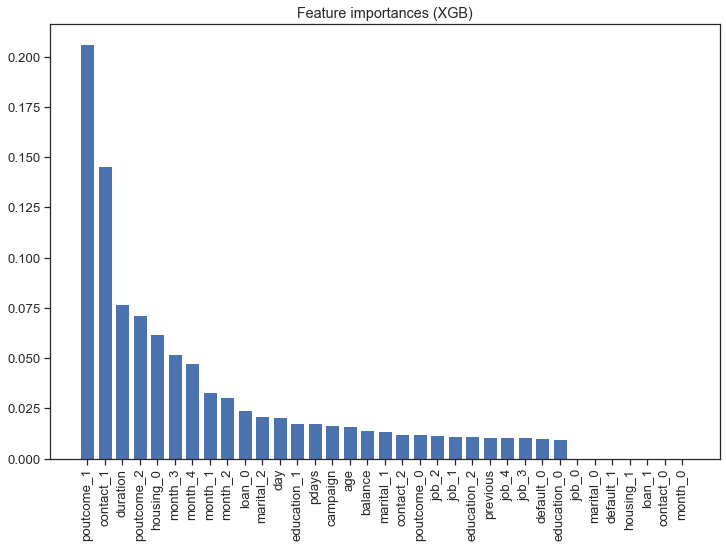

In [31]:
#feature importance
importances = model_XGB.best_estimator_.feature_importances_
headers = ["var", "score"]
values = sorted(zip(X_train.columns, importances), key=lambda x: x[1] * -1)
imp = pd.DataFrame(values, columns = headers)

#plot
x_pos = np.arange(0, len(imp))
plt.figure(figsize=(12,8))
plt.bar(x_pos, imp['score'])
plt.xticks(x_pos, imp['var'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

In [32]:
#%% pickle model
joblib_file = "joblib_XGB_Model.pkl" 
best_model = model_XGB.best_estimator_
joblib.dump(model_XGB, joblib_file)

['joblib_XGB_Model.pkl']

# Evaluating models

In [116]:
Model_LogR = joblib.load('joblib_log_Model.pkl')
Model_LogRSMOTE = joblib.load('joblib_logSMOTE_Model.pkl')
Model_RF = joblib.load('joblib_RF_Model.pkl')
Model_XG = joblib.load('joblib_XGB_Model.pkl')

In [117]:
#%% evaluate
for model in (Model_LogR, Model_LogRSMOTE, Model_RF, Model_XG):
    y_pred = model.predict(X_test)
    name =[x for x in globals() if globals()[x] is model][0]
    print('--')
    print("%s" % name)
    print('accuracy:', '%.2f' % accuracy_score(y_test, y_pred))
    print('precision:', '%.2f' % precision_score(y_test,y_pred))
    print('recall:', '%.2f' % recall_score(y_test,y_pred))
    print('F1', '%.2f' % f1_score(y_test,y_pred))
    print('ROC AUC:','%.2f' % roc_auc_score(y_test, y_pred))

--
model
accuracy: 0.88
precision: 0.50
recall: 0.17
F1 0.26
ROC AUC: 0.57
--
model
accuracy: 0.74
precision: 0.23
recall: 0.47
F1 0.31
ROC AUC: 0.63
--
Model_RF
accuracy: 0.79
precision: 0.29
recall: 0.46
F1 0.36
ROC AUC: 0.65
--
Model_XG
accuracy: 0.66
precision: 0.21
recall: 0.65
F1 0.32
ROC AUC: 0.66


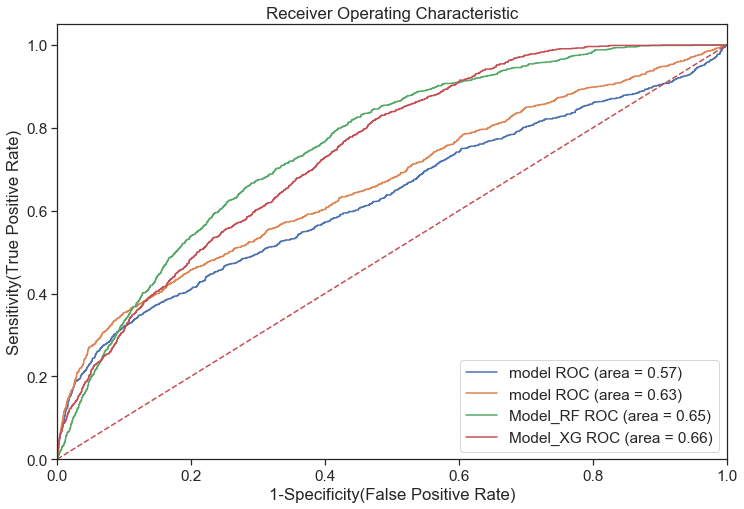

In [115]:
plt.figure(figsize=(12,8))

for model in (Model_LR, Model_LR_SMOTE, Model_RF, Model_XG):
    y_pred = model.predict(X_test) # predict the test data
    name =[x for x in globals() if globals()[x] is model][0]
# Compute False postive rate, True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve 
    auc = roc_auc_score(y_test,model.predict(X_test))
# Plot values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
# Customize plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 